# Binary classification using Pre-trained models on DAGM-2007 dataset

In this notebook I will try to binary classification of DAGM 2007 dataset. You can find the dataset in this link : https://conferences.mpi-inf.mpg.de/dagm/2007/prizes.html

This notebook will show how I will use image-processing using OpenCV to enhance dataset before training. I will show the process for one dataset. But image-processing functions for all  the datasets are given and should work.

### Import module

In [2]:
import tensorflow as tf
from tensorflow import set_random_seed

import matplotlib.pyplot as plt

from PIL import Image, ImageEnhance
import pandas as pd
import cv2 as cv 
import cv2
import sys
import matplotlib.pyplot as plt
import skimage
import os
import re
from tqdm import tqdm
import numpy as np
from numpy.random import seed 
seed(0)
import random


from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

from keras import backend as k 
from keras import optimizers
from keras import applications
from keras import layers
from keras import models
from keras import callbacks
from keras import optimizers

from keras.backend import tensorflow_backend
from keras.preprocessing import image

from keras.utils.np_utils import to_categorical

from keras.applications.vgg16 import VGG16
from keras.applications import inception_v3
from keras.applications.inception_v3 import InceptionV3
from keras.applications import xception
from keras.applications import resnet50
from keras.applications.vgg16 import preprocess_input, decode_predictions

from keras.utils import np_utils

from keras.regularizers import l2

from keras.preprocessing import image
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, Model 

from keras.layers import Activation
from keras.layers import merge, Input
from keras.layers import LeakyReLU
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.layers import Conv2D,Dropout,BatchNormalization,Dense,MaxPooling2D,ZeroPadding2D

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
img_width, img_height = 224, 224

from keras.applications.imagenet_utils import preprocess_input

import keras
from keras.models import Model
from keras.models import load_model


import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2 as cv
from PIL import Image, ImageEnhance
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers , optimizers
from keras.layers import Input
from keras.applications import models

from keras.applications import VGG16

from keras.utils import np_utils
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model 

Since we will be using image data, we will be constantly trying to see images. So I prepared a function that I can call everytime I want to see an image

In [3]:
def c(img):
    plt.figure(figsize=(8,8))
    plt.grid(True)
    plt.imshow(img,cmap='gray')
    plt.show()


We will be checking F1 score and confusion matrix after training. So I have prepared a confusion matrix and F1 score function is prepared that can be called later

In [4]:
def f1ScoreAndConfusionMatrix(yActual,yPrediction,color='Blues'):
    """ first --> yActual
    second ---> yPrediction
    it will produce both f1 score and confusion matrix 
    return f1,cm"""
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import f1_score
    f1 = f1_score(yActual,yPrediction)
    cm = confusion_matrix(yActual,yPrediction)
    print('\nConfusion Matrix:\n',cm)
    t1=cm[0,:]/sum(cm[0,:])
    t2=cm[1,:]/sum(cm[1,:])
    cm=np.array(list([t1,t2]))
    ax= plt.subplot()
    print('\nConfusion Matrix (as Percentage)')
    sns.heatmap(cm.astype(float), annot=True, ax = ax,cmap=color,fmt='g');
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['bad', 'good']); ax.yaxis.set_ticklabels(['bad', 'good'])
    plt.show()
    
    print('Bad data detection probability: ',cm[0][0])
    print('Good data detection probability:',cm[1][1])
    print('F1 score',f1)
    return f1,cm

One-hot encoder and decoder function

In [5]:
def OneHotEncodeDecoder(X):
    """ imodel.add(Dense, activation='relu'))
f we give an one hot encoded version of list, it will give us the original list"""
    import numpy as np
    return [np.argmax(i) for i in X]


let's make a function to make our directory tree and also another function to remove internal contents so if you run the code twice for the same dataset, data will not be duplicated

In [6]:
def make_directory(directory_name):
    try:
        os.makedirs(directory_name)
    except:FileExistsError

In [7]:
def remove_directory_contents(dir_name):
    from shutil import rmtree
    rmtree(dir_name)
    make_directory(dir_name)

### Data augmentation and balancing

the DAGM dataset for each class consists 1000 good images and 150 bad images. To avoid this bias, we will use Augmentor to augment data and balance the dataset so train/val/test datasets will have consistent and unbiased set of data. This function will be used to augment and prepare train test and validation dataset.

In [8]:
def train_test_val_generator(num):
    """num=which open data directory"""
    from shutil import copyfile,move
    import Augmentor
    try:
        remove_directory_contents('problem'+str(num))
    except: FileNotFoundError
    try:
        os.makedirs('problem'+str(num)+'/train/good')
        os.makedirs('problem'+str(num)+'/train/bad')
        os.makedirs('problem'+str(num)+'/test/good')
        os.makedirs('problem'+str(num)+'/test/bad')
        os.makedirs('problem'+str(num)+'/val/good')
        os.makedirs('problem'+str(num)+'/val/bad')
    except: FileExistsError

    goodArr=os.listdir('Class'+str(num))
    goodArr=[i for i in goodArr if i.endswith('png')] #a condition to ignore ipython checkpoint
    goodArr=[os.path.join('Class'+str(num),i) for i in goodArr]  #to create a path
    goodArr=random.sample(goodArr,999) 
    for i in range (334):
        src=goodArr[i]
        dst=os.path.join('problem'+str(num)+'/train/good', goodArr[i][7:])
        copyfile(src,dst)

    for i in range (334,667):
        src=goodArr[i]
        dst=os.path.join('problem'+str(num)+'/test/good', goodArr[i][7:])
        copyfile(src,dst)
    for i in range (667,999):
        src=goodArr[i]
        dst=os.path.join('problem'+str(num)+'/val/good', goodArr[i][7:])
        copyfile(src,dst)

    badArr=os.listdir('Class'+str(num)+'_def')
    badArr=[i for i in badArr if i.endswith('png')] #a condition to ignore ipython checkpoint
    badArr=[os.path.join('Class'+str(num)+'_def',i) for i in badArr]  #to create a path
    random.shuffle(badArr)

    for i in range (50):
        src=badArr[i]
        dst=os.path.join('problem'+str(num)+'/train/bad', badArr[i][11:])
        copyfile(src,dst)

    for i in range (50,100):
        src=badArr[i]
        dst=os.path.join('problem'+str(num)+'/test/bad', badArr[i][11:])
        copyfile(src,dst)

    for i in range (100,150):
        src=badArr[i]
        dst=os.path.join('problem'+str(num)+'/val/bad', badArr[i][11:])
        copyfile(src,dst)


    p=Augmentor.Pipeline('problem'+str(num)+'/train/bad/')

    p.rotate90(probability=1.0)
    p.process()
    p.rotate180(probability=1.0)
    p.process()
    p.rotate270(probability=1.0)
    p.process()

    source=(os.listdir('problem'+str(num)+'/train/bad/output'))
    source=[i for i in source if i.endswith('png')]

    for i in range(len(source)):
        src=os.path.join('problem'+str(num)+'/train/bad/output',source[i])
        dst=os.path.join('problem'+str(num)+'/train/bad',src[26:])
        move(src,dst)
    os.removedirs('problem'+str(num)+'/train/bad/output')


    p=Augmentor.Pipeline('problem'+str(num)+'/test/bad/')

    p.rotate90(probability=1.0)
    p.process()
    p.rotate180(probability=1.0)
    p.process()
    p.rotate270(probability=1.0)
    p.process()


    source=(os.listdir('problem'+str(num)+'/test/bad/output'))
    source=[i for i in source if i.endswith('png')]

    for i in range(len(source)):
        src=os.path.join('problem'+str(num)+'/test/bad/output',source[i])
        dst=os.path.join('problem'+str(num)+'/test/bad',src[25:])
        move(src,dst)

    os.removedirs('problem'+str(num)+'/test/bad/output')
    p=Augmentor.Pipeline('problem'+str(num)+'/val/bad/')
    p.rotate90(probability=1.0)
    p.process()
    p.rotate180(probability=1.0)
    p.process()
    p.rotate270(probability=1.0)
    p.process()

    source=(os.listdir('problem'+str(num)+'/val/bad/output'))
    source=[i for i in source if i.endswith('png')]

    for i in range(len(source)):
        src=os.path.join('problem'+str(num)+'/val/bad/output',source[i])
        dst=os.path.join('problem'+str(num)+'/val/bad',src[24:])
        move(src,dst)
    os.removedirs('problem'+str(num)+'/val/bad/output')

    print(len(os.listdir('problem'+str(num)+'/train/good')))
    print(len(os.listdir('problem'+str(num)+'/train/bad')))
    print(len(os.listdir('problem'+str(num)+'/test/good')))
    print(len(os.listdir('problem'+str(num)+'/test/bad')))
    print(len(os.listdir('problem'+str(num)+'/val/good')))
    print(len(os.listdir('problem'+str(num)+'/val/bad')))
    
    

xTrain xVal xTest generator function from image folder

In [9]:
def xTrain_xVal_xTest_from_train_test_val_folders(num,size,image_processing=True):
    trainGoodArr=os.listdir('problem'+str(num)+'/train/good/')
    trainGoodArr=[i for i in trainGoodArr if i.endswith('png')]
    trainGoodArr=['problem'+str(num)+'/train/good/'+i for i in trainGoodArr]
    df1=pd.DataFrame({'paths':trainGoodArr,'result':np.ones(len(trainGoodArr))})


    trainBadArr=os.listdir('problem'+str(num)+'/train/bad/')
    trainBadArr=[i for i in trainBadArr if i.endswith('png')]
    trainBadArr=['problem'+str(num)+'/train/bad/'+i for i in trainBadArr]
    df2=pd.DataFrame({'paths':trainBadArr,'result':np.zeros(len(trainBadArr))})

    valGoodArr=os.listdir('problem'+str(num)+'/val/good/')
    valGoodArr=[i for i in valGoodArr if i.endswith('png')]
    valGoodArr=['problem'+str(num)+'/val/good/'+i for i in valGoodArr]
    df3=pd.DataFrame({'paths':valGoodArr,'result':np.ones(len(valGoodArr))})


    valBadArr=os.listdir('problem'+str(num)+'/val/bad/')
    valBadArr=[i for i in valBadArr if i.endswith('png')]
    valBadArr=['problem'+str(num)+'/val/bad/'+i for i in valBadArr]
    df4=pd.DataFrame({'paths':valBadArr,'result':np.zeros(len(valBadArr))})

    testGoodArr=os.listdir('problem'+str(num)+'/test/good/')
    testGoodArr=[i for i in testGoodArr if i.endswith('png')]
    testGoodArr=['problem'+str(num)+'/test/good/'+i for i in testGoodArr]
    df5=pd.DataFrame({'paths':testGoodArr,'result':np.ones(len(testGoodArr))})


    testBadArr=os.listdir('problem'+str(num)+'/test/bad/')
    testBadArr=[i for i in testBadArr if i.endswith('png')]
    testBadArr=['problem'+str(num)+'/test/bad/'+i for i in testBadArr]
    df6=pd.DataFrame({'paths':testBadArr,'result':np.zeros(len(testBadArr))})
    
    traindf = pd.concat([df1, df2], ignore_index=True)
    traindf = traindf.sample(len(traindf))
    valdf = pd.concat([df3, df4], ignore_index=True)
    valdf = valdf.sample(len(valdf))
    testdf = pd.concat([df5, df6], ignore_index=True)
    testdf = testdf.sample(len(testdf))

    if image_processing == False:
        xTrain = np.array([ cv.resize((cv.imread(traindf.paths.values[i])),(size,size))  for i in range(len(traindf))])
        yTrain = traindf.result.values
        yTrain=np_utils.to_categorical(yTrain, 2)

        xVal = np.array([ cv.resize((cv.imread(valdf.paths.values[i])),(size,size))  for i in range(len(valdf))])
        yVal = valdf.result.values
        yVal=np_utils.to_categorical(yVal, 2)

        xTest = np.array([ cv.resize((cv.imread(testdf.paths.values[i])),(size,size))  for i in range(len(testdf))])
        yTest = testdf.result.values
        yTest=np_utils.to_categorical(yTest, 2)
    else:
        xTrain = np.array([ cv.resize(image_processing_function(cv.imread(traindf.paths.values[i])),(size,size))  for i in range(len(traindf))])
        yTrain = traindf.result.values
        yTrain=np_utils.to_categorical(yTrain, 2)

        xVal = np.array([ cv.resize(image_processing_function(cv.imread(valdf.paths.values[i])),(size,size))  for i in range(len(valdf))])
        yVal = valdf.result.values
        yVal=np_utils.to_categorical(yVal, 2)

        xTest = np.array([ cv.resize(image_processing_function(cv.imread(testdf.paths.values[i])),(size,size))  for i in range(len(testdf))])
        yTest = testdf.result.values
        yTest=np_utils.to_categorical(yTest, 2)
        

    xTrain = xTrain/255
    xVal = xVal/255
    xTest = xTest/255
    return xTrain,yTrain,xVal,yVal,xTest,yTest

This function will generate heatmap. What this will do is it will take the final conv layers output and generate heatmap. Then it will overlap the heatmap on the actual image and show output. This way we can see what the neural network sees to classify the image

In [10]:
def showHeatMap(classnum,photoID,badIndex=0):
    import cv2
    # The local path to our target image
    img_path = 'Class'+str(classnum)+'_def/'+str(photoID)+'.png'

    x = cv2.resize(image_processing_function(cv2.imread(img_path)),(224,224))

    
    
    
    #

    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    x = np.expand_dims(x, axis=0)

    # Finally we preprocess the batch
    # (this does channel-wise color normalization)
    #x = preprocess_input(x)
    x=x.astype(float)/255
    class_output = bestModel.output[:, badIndex]
    last_conv_layer = bestModel.get_layer("block5_conv3")

    from keras import backend as K
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([bestModel.input], [pooled_grads, last_conv_layer.output[0]])

    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    img=heatmap.copy()
    cmap = plt.get_cmap('viridis')
    rgba_img = cmap(img)
    rgb_img = np.delete(rgba_img, 3, 2)    
    from PIL import Image
    import cv2 as cv
    rgb_img_resized=(cv.resize(rgb_img,(224,224))*255)
    #plt.imshow(rgb_img_resized)
    rgb_img_resized=Image.fromarray(np.uint8(rgb_img_resized))  

    originalimage=cv.resize(cv.imread('Class'+str(classnum)+'_def/'+str(photoID)+'.png'),(224,224))
    originalimage=Image.fromarray(originalimage)
    
    background = originalimage.convert("RGBA")
    overlay = rgb_img_resized.convert("RGBA")
    new_img = Image.blend(background, overlay, 0.3)
    
    
    
    frame=np.array(rgb_img_resized)

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    lower_red = np.array([50,0,0])
    upper_red = np.array([100,255,255])

    mask = cv2.inRange(hsv, lower_red, upper_red)
    res = cv2.bitwise_and(frame,frame, mask= mask)
    
    #res = cv2.bitwise_and(frame,frame, mask= mask)
    #res[np.where((res==[0,0,0]).all(axis=2))]=[255,255,255]
    background = originalimage.convert("RGBA")
    overlayH=Image.fromarray(res)
    overlayH = overlayH.convert("RGBA")
    new_imgH = Image.blend(background, overlayH, 0.3)
    
    
    
    fig = plt.figure(figsize=(20,80))
    plt.subplot(1, 4, 1)
    plt.imshow(cv.imread('Class'+str(classnum)+'_def/'+str(photoID)+'.png'))
    plt.subplot(1, 4, 2)
    plt.imshow(heatmap)
    plt.subplot(1,4,3)
    plt.imshow(new_img)
    plt.subplot(1,4,4)
    plt.imshow(new_imgH)
    
    plt.show()

### Image processing functions

As said before, DAGM has 6 types of images as dataset. Each class is unique and requires its own image processing. here are the image processing functions for each class to get the best results.

We will be going forward with class 6 as our example

In [3]:
### for class 1


# def image_processing_function(img):
#     edges = cv.Canny(img,50,100)
#     return cv.merge((edges,edges,edges))

### for class 2


# def image_processing_function(img):
#     contrasted_img = cv.addWeighted(img,2,np.zeros(img.shape,img.dtype),0,65)
#     ret,thresh1 = cv2.threshold(contrasted_img,70,255,cv2.THRESH_BINARY)
#     return thresh1

### for class 3

# def image_processing_function(img):
#     kernel = np.ones((3,3),np.uint8)
#     gradient = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel); #c(gradient)
#     ret,thresh1 = cv2.threshold(gradient,70,255,cv2.THRESH_BINARY);#c(thresh1)
#     return thresh1


### for class 4 and 5

# def image_processing_function(img):
#     kernel = np.ones((2,2),np.uint8)
#     gradient = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel);# c(gradient)
#     #edges = cv2.Canny(gradient,50,50) ; c(edges)
#     ret,thresh1 = cv2.threshold(gradient,40,255,cv2.THRESH_BINARY);# c(thresh1)
#     return thresh1


### for class 6

def image_processing_function(img):
    contrasted_img = cv.addWeighted(img,2,np.zeros(img.shape,img.dtype),0,65)
    ret,thresh1 = cv2.threshold(contrasted_img,70,255,cv2.THRESH_BINARY)
    return thresh1

Insert the number of class that  you want to use. We will be using class 6.

In [12]:
train_test_val_generator(6)

Processing <PIL.Image.Image image mode=L size=512x512 at 0x1E658B485F8>:   8%|▎   | 4/50 [00:00<00:02, 16.44 Samples/s]

Initialised with 50 image(s) found.
Output directory set to problem6/train/bad/output.

Processing <PIL.Image.Image image mode=L size=512x512 at 0x1E657A40978>: 100%|██| 50/50 [00:00<00:00, 192.08 Samples/s]
Processing <PIL.Image.Image image mode=L size=512x512 at 0x1E658B609E8>: 100%|██| 50/50 [00:00<00:00, 189.18 Samples/s]
Processing <PIL.Image.Image image mode=L size=512x512 at 0x1E658B5A4E0>: 100%|██| 50/50 [00:00<00:00, 195.84 Samples/s]
Processing <PIL.Image.Image image mode=L size=512x512 at 0x1E658B48BA8>:  14%|▌   | 7/50 [00:00<00:06,  6.64 Samples/s]

Initialised with 50 image(s) found.
Output directory set to problem6/test/bad/output.

Processing <PIL.Image.Image image mode=L size=512x512 at 0x1E657A5B978>: 100%|██| 50/50 [00:00<00:00, 195.86 Samples/s]
Processing <PIL.Image.Image image mode=L size=512x512 at 0x1E6579B6908>: 100%|██| 50/50 [00:00<00:00, 192.82 Samples/s]
Processing <PIL.Image.Image image mode=L size=512x512 at 0x1E658B609E8>: 100%|███| 50/50 [00:00<00:00, 78.29 Samples/s]
Processing <PIL.Image.Image image mode=L size=512x512 at 0x1E658B65240>:  10%|▍   | 5/50 [00:00<00:04,  9.20 Samples/s]

Initialised with 50 image(s) found.
Output directory set to problem6/val/bad/output.

Processing <PIL.Image.Image image mode=L size=512x512 at 0x1E657A336A0>: 100%|███| 50/50 [00:00<00:00, 94.94 Samples/s]
Processing <PIL.Image.Image image mode=L size=512x512 at 0x1E657A4F4E0>: 100%|██| 50/50 [00:00<00:00, 165.20 Samples/s]
Processing <PIL.Image.Image image mode=L size=512x512 at 0x1E657A40860>: 100%|██| 50/50 [00:00<00:00, 163.30 Samples/s]


334
200
333
200
332
200


In the parameters, num represents the number of class. We are using class 6.
If you want to use the image processing functions, then  turn image_processing to True

In [13]:
xTrain,yTrain,xVal,yVal,xTest,yTest = xTrain_xVal_xTest_from_train_test_val_folders(num=6,image_processing=True,size=224)

We will prepare the model here. We will be using VGG16. We have added a few layers.

Since we do not need to train the entire network. We will be freezing the top portion of the network and only train the last 8 layers of the model.

In [ ]:
from keras.optimizers import Adam
image_input= Input(shape=(224,224,3))
model=VGG16(input_tensor=image_input, include_top=True, weights='imagenet')
last_layer = model.get_layer('flatten').output
last_layer = Dense(256, activation='relu',name='second_last')(last_layer)
last_layer = Dropout(.7,name='drop')(last_layer)
out = Dense(2, activation='softmax', name='output')(last_layer)
custom_vgg_model = Model(image_input, out)
#custom_vgg_model.summary()
for layer in custom_vgg_model.layers[:-8]:
	layer.trainable = False
# custom_vgg_model.layers[:-4].trainable

custom_vgg_model.summary()



In [15]:
for i, layer in enumerate(custom_vgg_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 flatten True
20 second_last True
21 drop True
22 output True


In [16]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='min')
checkpoint = ModelCheckpoint('newM.hdf5', monitor='val_loss', save_best_only=True, mode='min')

In [17]:
batch_size = 16
custom_vgg_model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.adam(lr=1e-6),metrics=['accuracy'])
hist = custom_vgg_model.fit(xTrain, yTrain, batch_size=batch_size, epochs=50, verbose=1, validation_data=(xVal,yVal),
                            callbacks=[early_stopping,checkpoint]) 

Train on 534 samples, validate on 532 samples
Epoch 1/50
534/534 [==============================] - 304s 570ms/step - loss: 0.9649 - acc: 0.4513 - val_loss: 0.6421 - val_acc: 0.8459
Epoch 2/50
534/534 [==============================] - 303s 567ms/step - loss: 0.7759 - acc: 0.5768 - val_loss: 0.5820 - val_acc: 0.6729
Epoch 3/50
534/534 [==============================] - 303s 567ms/step - loss: 0.7370 - acc: 0.6199 - val_loss: 0.5514 - val_acc: 0.6410
Epoch 4/50
534/534 [==============================] - 303s 567ms/step - loss: 0.6733 - acc: 0.6404 - val_loss: 0.5210 - val_acc: 0.6955
Epoch 5/50
534/534 [==============================] - 303s 567ms/step - loss: 0.6639 - acc: 0.6386 - val_loss: 0.4903 - val_acc: 0.7312
Epoch 6/50
534/534 [==============================] - 303s 568ms/step - loss: 0.5896 - acc: 0.6854 - val_loss: 0.4566 - val_acc: 0.7820
Epoch 7/50
534/534 [==============================] - 304s 570ms/step - loss: 0.5203 - acc: 0.7453 - val_loss: 0.4203 - val_acc: 0.8440
Ep

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

let's call  the F1 score and confusion matrix function that we generated and see how the moodel performs on test data


Evaluation on Best Validation:
533/533 [==============================] - 145s 272ms/step
Accuracy:  0.9962476547842402

Confusion Matrix:
 [[198   2]
 [  0 333]]

Confusion Matrix (as Percentage)


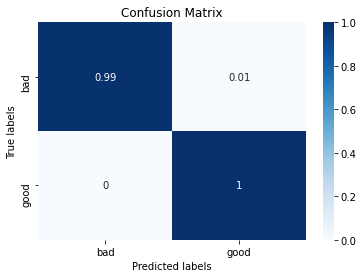

Bad data detection probability:  0.99
Good data detection probability: 1.0
F1 score 0.997005988023952


In [19]:
bestModel=load_model('newM.hdf5')
print('\nEvaluation on Best Validation:')

print('Accuracy: ',bestModel.evaluate(xTest,yTest)[1])

preds=bestModel.predict(xTest)
predicted_class = []
for i in preds:
    if i[0]>i[1]:
        predicted_class.append(0)
    else:
        predicted_class.append(1)
f1,cm=f1ScoreAndConfusionMatrix(OneHotEncodeDecoder(yTest),predicted_class)

For reference we will compare our result with **SVM** method.

In [20]:
image_h = 224
image_w = 224

In [24]:
def extract_vgg16(X):
    vgg16_model = VGG16(input_shape=(image_h, image_w, 3), weights='imagenet', include_top=False)
    features_array = vgg16_model.predict(X)
    return features_array
model=VGG16(input_shape=(image_h, image_w, 3), weights='imagenet', include_top=False)


np.random.seed(42) #20 #42 not bad as well
train = os.listdir('Class4/')
train = [i for i in train if i.endswith('png')]
train=['Class4/'+i for i in train]
np.random.shuffle(train)

testBad = os.listdir('Class4_def/')
testBad = [i for i in testBad if i.endswith('png')]
#trainfood = [i for i in train if i[0]=='1']
testBad=['Class4_def/'+i for i in testBad]
testGood = train[850:]
test=testBad+testGood
yTest = list(np.zeros(150).astype(int))+list(np.ones(150).astype(int))

In [25]:
from sklearn.decomposition import PCA
from sklearn import svm
import seaborn as sns
from sklearn.ensemble import IsolationForest

initial xTrain shape (850, 224, 224, 3)
feature extracted xTrain shape (850, 7, 7, 512)
flattened xTrain shape (850, 25088)
last xTrain shape after PCA (850, 720)
last xTest shape after PCA (300, 720)
Confusion Matrix:
[[0.86       0.14      ]
 [0.17333333 0.82666667]]


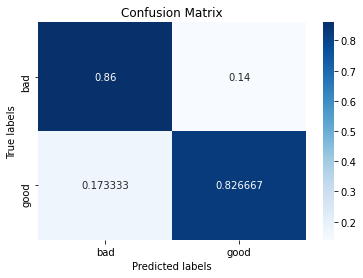

Bad data detection probability:  0.86
Good data detection probability: 0.8266666666666667
F1 score 0.840677966101695
Confusion Matrix:
[[0.84 0.16]
 [0.16 0.84]]


E:\Anaconda3\envs\my_env\lib\site-packages\sklearn\ensemble\_iforest.py:255: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


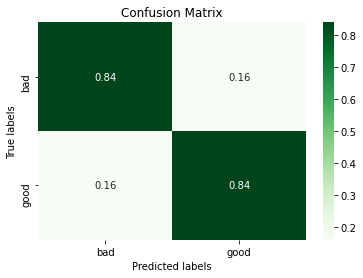

Bad data detection probability:  0.84
Good data detection probability: 0.84
F1 score 0.8399999999999999


In [26]:
def getxTrainxTest(algoFunctionName):

    xTrainNonFeatured = np.array([cv.resize(cv.imread(train[i]),(224,224)) for i in range(850)])
    print('initial xTrain shape',xTrainNonFeatured.shape)
    xTrain = eval(str(algoFunctionName))(xTrainNonFeatured)
    print('feature extracted xTrain shape',xTrain.shape)

    newXtrain=[]
    for i in xTrain:
        newXtrain.append(i.reshape(xTrain.shape[1]*xTrain.shape[2]*xTrain.shape[3]))
    xTrain=np.array(newXtrain)

    print('flattened xTrain shape',xTrain.shape)

    xTestNonFeatured = np.array([cv.resize(cv.imread(test[i]),(224,224)) for i in range(len(test))])

    xTest = eval(str(algoFunctionName))(xTestNonFeatured)


    newXtest=[]
    for i in xTest:
        newXtest.append(i.reshape(xTest.shape[1]*xTest.shape[2]*xTest.shape[3]))
    xTest=np.array(newXtest)


    # ########

    ss = StandardScaler()
    ss.fit(xTrain)
    X_train = ss.transform(xTrain)
    X_test = ss.transform(xTest)

    # Take PCA to reduce feature space dimensionality
    pca = PCA(n_components=720, whiten=True)
    pca = pca.fit(X_train)
    #print('Explained variance percentage = %0.2f' % sum(pca.explained_variance_ratio_))
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
    print('last xTrain shape after PCA',X_train.shape)
    print('last xTest shape after PCA',X_test.shape)
    return X_train, X_test



def getSVMresult(X_train,X_test,printYpred=True,gamma='scale',kernel='rbf',nu=.52):
    
    oc_svm_clf = svm.OneClassSVM(gamma=gamma, kernel=kernel,nu=nu)  # Obtained by hyperparameter tuning
    oc_svm_clf.fit(X_train)
    yPred = oc_svm_clf.predict(X_test)
    if printYpred == True:
        print(yPred)

    for i in range(len(yPred)):
        if yPred[i] == -1:
            yPred[i]=0

    cm=confusion_matrix(yTest,yPred)
    cm=cm/(len(yTest)/2)
    print('Confusion Matrix:')
    print(cm)
    ax= plt.subplot()
    sns.heatmap(cm.astype(float), annot=True, ax = ax,cmap='Blues',fmt='g');
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['bad', 'good']); ax.yaxis.set_ticklabels(['bad', 'good'])
    plt.show()
    f1Score = f1_score(yTest,yPred)
    print('Bad data detection probability: ',cm[0][0])
    print('Good data detection probability:',cm[1][1])
    print('F1 score',f1Score)
    return yPred,f1Score


def getIFresult(X_train,X_test,printYpred=True,contamination=0.3, max_features=.7, max_samples=.5, n_estimators=25 ,behaviour='new'):
    if_clf = IsolationForest(contamination=contamination, max_features=max_features, max_samples=max_samples, n_estimators=n_estimators ,behaviour=behaviour)  # Obtained using grid search
    if_clf.fit(X_train)
    yPred = if_clf.predict(X_test)
    if printYpred == True:
        print(yPred)

    for i in range(len(yPred)):
        if yPred[i] == -1:
            yPred[i]=0

    cm=confusion_matrix(yTest,yPred)
    cm=cm/(len(yTest)/2)
    print('Confusion Matrix:')
    print(cm)
    ax= plt.subplot()
    sns.heatmap(cm.astype(float), annot=True, ax = ax,cmap='Greens',fmt='g');
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['bad', 'good']); ax.yaxis.set_ticklabels(['bad', 'good'])
    plt.show()
    f1Score = f1_score(yTest,yPred)
    print('Bad data detection probability: ',cm[0][0])
    print('Good data detection probability:',cm[1][1])
    print('F1 score',f1Score)
    return yPred,f1Score


X_train, X_test = getxTrainxTest('extract_vgg16')



vgg_svm,vgg_svm_f1=getSVMresult(X_train,X_test=X_test,nu=.52,printYpred=False)


vgg_if,vgg_if_f1= getIFresult(X_train,X_test,printYpred=False)

As you can see, the SVM performs nowhere near our Neural network. Now let's see the Heatmap of prediction!

### Heatmap generation

In [27]:
model=load_model('newM.hdf5') 

In [ ]:
model.summary()

In [28]:
def showHeatMap(classnum,photoID,badIndex=0):
    import cv2
    # The local path to our target image
    img_path = 'Class'+str(classnum)+'_def/'+str(photoID)+'.png'

    x = cv2.resize(image_processing_function(cv2.imread(img_path)),(224,224))

    
    
    
    #

    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    x = np.expand_dims(x, axis=0)

    # Finally we preprocess the batch
    # (this does channel-wise color normalization)
    #x = preprocess_input(x)
    x=x.astype(float)/255
    class_output = bestModel.output[:, badIndex]
    last_conv_layer = bestModel.get_layer("block5_conv3")

    from keras import backend as K
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([bestModel.input], [pooled_grads, last_conv_layer.output[0]])

    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    img=heatmap.copy()
    cmap = plt.get_cmap('viridis')
    rgba_img = cmap(img)
    rgb_img = np.delete(rgba_img, 3, 2)    
    from PIL import Image
    import cv2 as cv
    rgb_img_resized=(cv.resize(rgb_img,(224,224))*255)
    #plt.imshow(rgb_img_resized)
    rgb_img_resized=Image.fromarray(np.uint8(rgb_img_resized))  

    originalimage=cv.resize(cv.imread('Class'+str(classnum)+'_def/'+str(photoID)+'.png'),(224,224))
    originalimage=Image.fromarray(originalimage)
    
    background = originalimage.convert("RGBA")
    overlay = rgb_img_resized.convert("RGBA")
    new_img = Image.blend(background, overlay, 0.3)
    
    
    
    frame=np.array(rgb_img_resized)

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    lower_red = np.array([50,0,0])
    upper_red = np.array([100,255,255])

    mask = cv2.inRange(hsv, lower_red, upper_red)
    res = cv2.bitwise_and(frame,frame, mask= mask)
    
    #res = cv2.bitwise_and(frame,frame, mask= mask)
    #res[np.where((res==[0,0,0]).all(axis=2))]=[255,255,255]
    background = originalimage.convert("RGBA")
    overlayH=Image.fromarray(res)
    overlayH = overlayH.convert("RGBA")
    new_imgH = Image.blend(background, overlayH, 0.3)
    
    
    
    fig = plt.figure(figsize=(20,80))
    plt.subplot(1, 4, 1)
    plt.imshow(cv.imread('Class'+str(classnum)+'_def/'+str(photoID)+'.png'))
    plt.subplot(1, 4, 2)
    plt.imshow(heatmap)
    plt.subplot(1,4,3)
    plt.imshow(new_img)
    plt.subplot(1,4,4)
    plt.imshow(new_imgH)
    
    plt.show()

In [29]:
photoID =2
classnum = 6

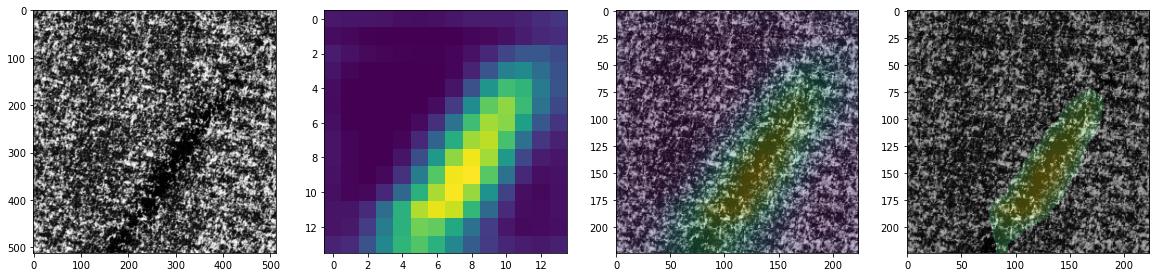

In [30]:
showHeatMap(classnum,photoID,badIndex =0)